In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor


store_sales = pd.read_csv('/home/tebrigabby/python/data_files/train (1).csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

/tmp/ipykernel_1778/4099051912.py:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv('/home/tebrigabby/python/data_files/train (1).csv',


In [10]:
# a boosted hybrid for the Store Sales dataset by implementing a new Python class.

# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

    # 1) Define fit method for boosted hybrid
    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=y.columns,
        )
    
        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long
    
        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)
    
        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid

    # Add method to class
    BoostedHybrid.fit = fit

In [11]:
# 2) Define predict method for boosted hybrid

def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict

In [12]:
# Now you're ready to use your new BoostedHybrid class to create a model for the Store Sales data.

# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [13]:
# 3) Train boosted hybrid

# Create LinearRegression + XGBRegressor hybrid with BoostedHybrid
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)

# Fit and predict
model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

In [14]:
# Depending on your problem, we might want to use other hybrid combinations than the linear regression + XGBoost

# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# YOUR CODE HERE: Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

/tmp/ipykernel_1778/3568620306.py:29: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
/tmp/ipykernel_1778/3568620306.py:30: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)


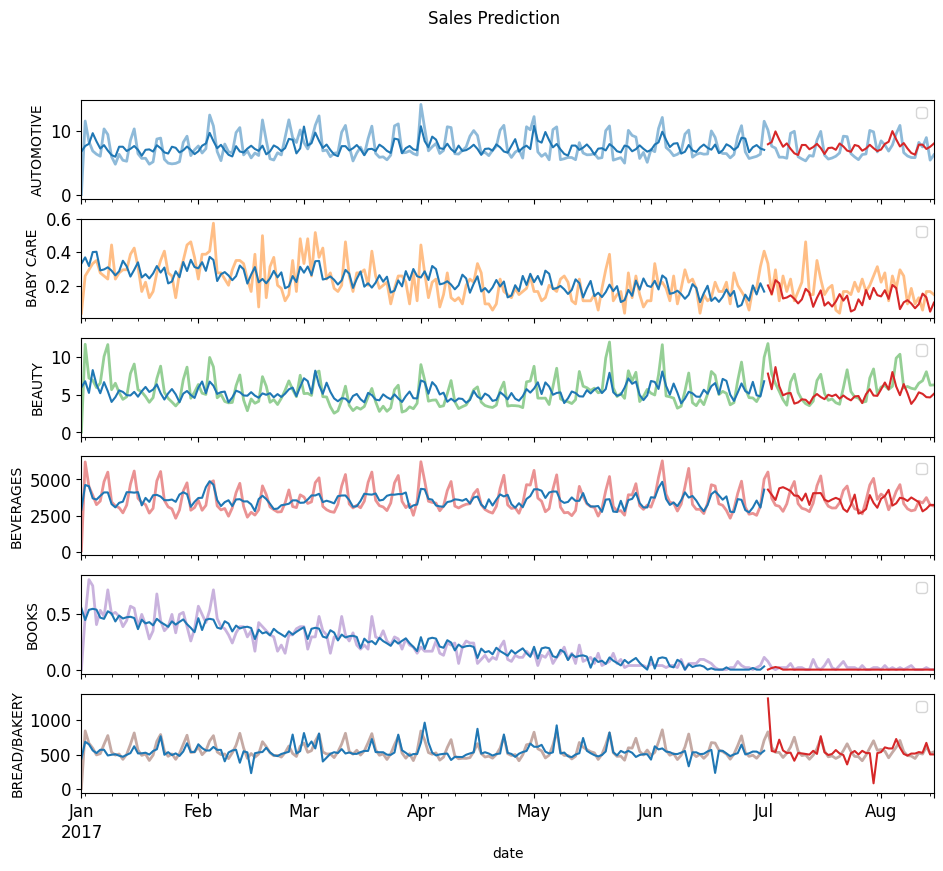

In [16]:
# Define plot parameters
plot_params = {
    'title': 'Sales Prediction',
    'xlabel': 'Date',
    'ylabel': 'Sales',
    'grid': True,  # Show grid lines
    'legend': True,  # Show legends
    'linewidth': 2,  # Line width
    'fontsize': 12,  # Font size for labels
}

# see the predictions your hybrid makes.

y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)